In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/embeddings-test/Abuse_Abuse006_x264_frame823.jpg
/kaggle/input/embeddings-test/Arson_Arson021_x264_frame641.jpg
/kaggle/input/embeddings-test/Arson_Arson034_x264_frame1882.jpg
/kaggle/input/embeddings-test/Arrest_Arrest039_x264_frame4424.jpg
/kaggle/input/embeddings-test/Arson_Arson046_x264_frame1934.jpg
/kaggle/input/embeddings-test/Abuse_Abuse001_x264_frame1128.jpg
/kaggle/input/embeddings-test/Abuse_Abuse037_x264_frame631.jpg
/kaggle/input/embeddings-test/Arrest_Arrest014_x264_frame922.jpg
/kaggle/input/embeddings-test/Arrest_Arrest017_x264_frame2655.jpg
/kaggle/input/embeddings-test/Arrest_Arrest028_x264_frame1961.jpg
/kaggle/input/embeddings-test/Arson_Arson022_x264_frame6508.jpg
/kaggle/input/embeddings-test/Abuse_Abuse048_x264_frame2470.jpg
/kaggle/input/embeddings-test/Arson_Arson012_x264_frame492.jpg
/kaggle/input/embeddings-test/Assault_Assault025_x264_frame832.jpg
/kaggle/input/embeddings-test/Abuse_Abuse010_x264_frame322.jpg
/kaggle/input/embeddings-test/Abuse

In [2]:
!pip install -q -U immutabledict sentencepiece 
!git clone https://github.com/google/gemma_pytorch.git

Cloning into 'gemma_pytorch'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 297 (delta 128), reused 80 (delta 80), pack-reused 117 (from 1)
Receiving objects: 100% (297/297), 5.53 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (166/166), done.


In [3]:

import torch
import os
import json
import gc
from torch import nn
from PIL import Image
from typing import Any, List, Sequence, Tuple, Union
import sys
sys.path.append("/kaggle/working/gemma_pytorch/") 
from gemma.config import get_model_config
from gemma import config as gemma_config
#from gemma.gemma3_model import Gemma3ForMultimodalLM

from gemma import tokenizer
from gemma import gemma3_model

from gemma import model as gemma_model
from gemma import config as gemma_config
from gemma import gemma3_preprocessor
from gemma import tokenizer
from gemma.siglip_vision import siglip_vision_model

class Gemma3ForMultimodalLM2(nn.Module):
  """Gemma3 model for multimodal causal LM."""
  def __init__(
        self,
        config: gemma_config.GemmaConfig,
    ):
    super().__init__()
    self.dtype = config.get_dtype()
    assert config.architecture == gemma_config.Architecture.GEMMA_3
    self.config = config
    max_seq_len = config.max_position_embeddings
    head_dim = config.head_dim
    vocab_size = config.vocab_size
    self.tokenizer = tokenizer.Tokenizer(config.tokenizer)
    self.text_token_embedder = gemma_model.Embedding(vocab_size, config.hidden_size, config.quant)
    self.model = gemma_model.GemmaModel(config)
    self.sampler = gemma_model.Sampler(vocab_size, config)

    if config.vision_config is None:
      raise ValueError('vision_config must be provided for Gemma3.')
    self.siglip_vision_model = siglip_vision_model.SiglipVisionModel(config.vision_config)
    # transformer/embedder/mm_soft_embedding_norm
    self.mm_soft_embedding_norm = gemma_model.RMSNorm(config.vision_config.embedding_dim,
                                                           eps = config.rms_norm_eps)
    # transformer/embedder/mm_input_projection
    self.mm_input_projection = gemma_model.Linear(config.vision_config.embedding_dim, config.hidden_size, config.quant)

    if config.rope_wave_length is None:
      raise ValueError('rope_wave_length must be provided for Gemma3.')
    rope_lengths = config.rope_wave_length
    defaults = {
            gemma_config.AttentionType.LOCAL_SLIDING: 10_000,
            gemma_config.AttentionType.GLOBAL: 10_000,
        }
    self._register_freqs_cis('local_freqs_cis', head_dim, max_seq_len, theta=rope_lengths.get(
              gemma_config.AttentionType.LOCAL_SLIDING, defaults[gemma_config.AttentionType.LOCAL_SLIDING]
          ))
    self._register_freqs_cis('global_freqs_cis', head_dim, max_seq_len, theta=rope_lengths.get(
              gemma_config.AttentionType.GLOBAL, defaults[gemma_config.AttentionType.GLOBAL]
          ), rope_scaling_factor=config.rope_scaling_factor)

  def _register_freqs_cis(
        self, name: str, head_dim: int, max_seq_len: int, theta: int = 10_000, rope_scaling_factor: int = 1
    ):
    self.register_buffer(
            name, gemma_model.precompute_freqs_cis(head_dim, max_seq_len * 2, theta=theta, rope_scaling_factor=rope_scaling_factor)
        )

  @torch.no_grad()
  def forward(self,
                input_token_ids: torch.Tensor, # B x L
                image_patches: torch.Tensor, # B x N x C x H x W (3x896x896)
                image_presence_mask: torch.Tensor, # B x N
                input_positions: torch.Tensor,
                kv_caches: List[Tuple[torch.Tensor, torch.Tensor]],
                mask: torch.Tensor,
                output_positions: torch.Tensor,
                temperatures: Union[torch.Tensor, None],
                top_ps: torch.Tensor,
                top_ks: torch.Tensor,
                local_mask: torch.Tensor | None = None,
                **kwargs) -> Tuple[torch.Tensor, torch.Tensor]:
    freqs_cis = {}
    freqs_cis[gemma_config.AttentionType.LOCAL_SLIDING] = (
            self.local_freqs_cis.index_select(0, input_positions)
        )
    freqs_cis[gemma_config.AttentionType.GLOBAL] = (
            self.global_freqs_cis.index_select(0, input_positions)
        )
    hidden_states = self.text_token_embedder(input_token_ids)
    normalizer = torch.tensor(self.config.hidden_size**0.5, dtype=hidden_states.dtype, device=hidden_states.device)
    hidden_states = hidden_states * normalizer
    if image_patches is not None and self.config.vision_config is not None:
      # the input has images
      B, N, C, H, W = image_patches.shape
      # Flatten and Pass to SiglipVisionModel, and apply SiglipVisionModel Exit
      flattened_input = image_patches.reshape(B * N, C, H, W)  # (B*N)xCxHxW
      image_embeddings = self.siglip_vision_model(flattened_input)  # (B*N)xUxD
      image_embeddings = self.mm_soft_embedding_norm(image_embeddings)  # (B*N) x U x D
      image_embeddings = self.mm_input_projection(image_embeddings)  # (B*N) x U x model_dim
      hidden_states = self.populate_image_embeddings(
          hidden_states.clone(),
          image_embeddings.clone(),
          input_token_ids.clone(),
          image_presence_mask.clone(),
      )

    kv_write_indices = input_positions

    hidden_states = self.model(
            hidden_states=hidden_states,
            freqs_cis=freqs_cis,
            kv_write_indices=kv_write_indices,
            kv_caches=kv_caches,
            mask=mask,
            local_mask=local_mask,
        )
    return hidden_states

  def populate_image_embeddings(self,
                                hidden_states: torch.Tensor, # B x L x model_dim
                                image_embeddings: torch.Tensor, # (B*N) x U x model_dim
                                input_token_ids: torch.Tensor, # B x L
                                image_presence_mask: torch.Tensor, # B x N
                                ):
    batch_size, seq_len, model_dim = hidden_states.shape
    # Step 1 of 2: Fetch valid image embeddings
    # flatten indices of valid image embeddings
    valid_image_embeddings_indices = torch.nonzero(image_presence_mask.flatten(), as_tuple=False).squeeze()
    # num_valid_images x model_dim
    valid_image_embeddings = image_embeddings.index_select(0, valid_image_embeddings_indices)

    # Step 2 of 2: Replace image embeddings at right places.
    image_placeholder_mask = input_token_ids == self.tokenizer.image_token_placeholder_id
    image_placeholder_indices = image_placeholder_mask.flatten().nonzero(as_tuple=False).squeeze()

    hidden_states = hidden_states.reshape(-1, self.config.hidden_size)
    hidden_states[image_placeholder_indices] = valid_image_embeddings.reshape(-1, self.config.hidden_size)
    return hidden_states.reshape(batch_size, seq_len, model_dim).contiguous()

  def create_attention_mask(self, input_ids: torch.Tensor, sequence_length: int):
    batch_size = input_ids.shape[0]
    causal_mask = torch.tril(torch.ones((batch_size, 1, sequence_length, sequence_length), dtype=torch.bool, device=input_ids.device))
    image_token_mask = input_ids == self.tokenizer.image_token_placeholder_id
    # Pad the mask to the left with 0. This is to make sure the boundary
    # detection works correctly. Boundary (starting index of image patch) is
    # detected when the value changes from 0 to 1.
    padded_mask = nn.functional.pad(image_token_mask, (1, 0), value=0)
    # Find the boundary (starting index) of the image tokens patch.
    boundary = padded_mask[:, 1:] > padded_mask[:, :-1]
    # Number the boundary.
    # boundary:
    # [[False, False,  True, False, False],
    #  [False,  True, False,  True, False]]
    # numbered_boundary:
    # [[0, 0, 1, 1, 1],
    #  [0, 1, 1, 2, 2]]
    numbered_boundary = torch.cumsum(boundary, dim=-1)

    # image_token_mask:
    # [[False, False,  True,  True, False],
    #  [True,  True, False,  True, True]]
    # numbered_boundary:
    # [[0, 0, 1, 1, 1],
    #  [1, 1, 1, 2, 2]]
    # q_block_indices:
    # [[0, 0, 1, 1, 0],
    #  [1, 1, 0, 2, 2]]
    q_block_indices = image_token_mask * numbered_boundary
    kv_block_indices = q_block_indices
    # Test the equality of vertical and horizontal numbered patches
    # to create the bidirectional mask.
    bidirectional_mask = torch.logical_and(
        kv_block_indices[:, None, :] == q_block_indices.unsqueeze(-1),
        q_block_indices.unsqueeze(-1) > 0,
    )
    attention_mask = torch.logical_or(causal_mask, bidirectional_mask.unsqueeze(1))
    # The upper triangular matrix's diagonal is shifted by sliding window size
    # before doing logical 'and' with attention mask. This is to make sure the
    # local attention is within the sliding window.
    local_mask = torch.logical_and(
            attention_mask,
            torch.triu(torch.ones((1, 1, sequence_length, sequence_length), dtype=torch.bool, device=input_ids.device), diagonal=-(self.config.sliding_window_size-1))
        )
    return attention_mask, local_mask

  def generate(
        self,
        prompts: Sequence[Sequence[Union[str, Image.Image]]],
        device: Any,
        output_len: int = 100,
        temperature: Union[float, None] = 1.0,
        top_p: float = 0.95,
        top_k: int = 64,
    ) -> Sequence[str]:
    """Generates responses for given prompts using Gemma model."""
    # Inference only.
    processing_result = gemma3_preprocessor.tokenize_raw_input(
            self.tokenizer, prompts, self.config, output_len, device
        )
    batch_size = processing_result["batch_size"]
    user_input_token_ids = processing_result["user_input_token_ids"]
    image_batch = processing_result["image_batch"]
    min_prompt_len = processing_result["min_prompt_len"]
    max_prompt_len = processing_result["max_prompt_len"]
    total_seq_len = processing_result["max_seq_len"]
    image_presence_mask = processing_result["image_presence_mask"]

    # Create attention mask.
    min_dtype = torch.finfo(self.dtype).min
    if self.config.sliding_window_size is None:
      raise ValueError('gemma 3 model requires sliding_window size')
    boolean_mask, local_boolean_mask = self.create_attention_mask(user_input_token_ids, total_seq_len)
    mask_tensor = torch.where(boolean_mask, 0, torch.tensor(min_dtype, dtype=torch.float32, device=device)).contiguous()
    local_mask_tensor = torch.where(local_boolean_mask, 0, torch.tensor(min_dtype, dtype=torch.float32, device=device)).contiguous()

    kv_caches = []
    for _ in range(self.config.num_hidden_layers):
      size = (batch_size, total_seq_len, self.config.num_key_value_heads,
                    self.config.head_dim)
      dtype = self.config.get_dtype()
      k_cache = torch.zeros(size=size, dtype=dtype, device=device)
      v_cache = torch.zeros(size=size, dtype=dtype, device=device)
      kv_caches.append((k_cache, v_cache))

    input_token_ids_tensor = torch.full((batch_size, min_prompt_len),
                                            self.tokenizer.pad_id,
                                            dtype=torch.int64, device=device)
    token_ids_tensor = user_input_token_ids.to(device)
    for i in range(batch_size):
      p = user_input_token_ids[i]
      input_token_ids_tensor[i, :min_prompt_len] = p[:min_prompt_len]

    input_positions_tensor = torch.arange(0, min_prompt_len, dtype=torch.int64, device=device)
    prompt_mask_tensor = token_ids_tensor != self.tokenizer.pad_id
    curr_mask_tensor = mask_tensor.index_select(2, input_positions_tensor)
    curr_local_mask_tensor = local_mask_tensor.index_select(2, input_positions_tensor)
    output_positions_tensor = torch.LongTensor([min_prompt_len - 1]).to(device)
    temperatures_tensor = None if not temperature else torch.FloatTensor(
            [temperature] * batch_size).to(device)
    top_ps_tensor = torch.FloatTensor([top_p] * batch_size).to(device)
    top_ks_tensor = torch.LongTensor([top_k] * batch_size).to(device)
    output_index = torch.tensor(min_prompt_len, dtype=torch.int64, device=device)


    return self(
            input_token_ids=input_token_ids_tensor,
            image_patches=image_batch,
            image_presence_mask=image_presence_mask,
            input_positions=input_positions_tensor,
            kv_caches=kv_caches,
            mask=curr_mask_tensor,
            output_positions=output_positions_tensor,
            temperatures=temperatures_tensor,
            top_ps=top_ps_tensor,
            top_ks=top_ks_tensor,
            local_mask=curr_local_mask_tensor,
        )


  def load_weights(self, model_path: str):
    if os.path.isfile(model_path):
      self.load_state_dict(
                torch.load(
                    model_path, mmap=True, weights_only=True,
                )['model_state_dict'],
                strict=False,
            )
    else:
      index_path = os.path.join(model_path, 'pytorch_model.bin.index.json')
      with open(index_path, "r", encoding="utf-8") as f:
        index = json.load(f)
      shard_files = list(set(index["weight_map"].values()))
      for shard_file in shard_files:
        shard_path = os.path.join(model_path, shard_file)
        state_dict = torch.load(shard_path, map_location="cpu", weights_only=True)
        self.load_state_dict(state_dict, strict=False)
        del state_dict  # Save memory.
        gc.collect()

In [4]:


import contextlib
import torch
import os
import kagglehub
# Choose variant and machine type
VARIANT = '4b'
MACHINE_TYPE = 'cpu'
OUTPUT_LEN = 20
METHOD = 'it'

weights_dir = kagglehub.model_download(f"google/gemma-3/pytorch/gemma-3-{VARIANT}-{METHOD}/1")
tokenizer_path = os.path.join(weights_dir, 'tokenizer.model')
ckpt_path = os.path.join(weights_dir, f'model.ckpt')

# Set up model config.
model_config = get_model_config(VARIANT)
model_config.dtype = "float32" if MACHINE_TYPE == "cpu" else "float16"

model_config.tokenizer = tokenizer_path

@contextlib.contextmanager
def _set_default_tensor_type(dtype: torch.dtype):
    """Sets the default torch dtype to the given dtype."""
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)

# Instantiate the model and load the weights.
device = torch.device(MACHINE_TYPE)
with _set_default_tensor_type(model_config.get_dtype()):
    model = Gemma3ForMultimodalLM2(model_config)
    model.load_state_dict(torch.load(ckpt_path)['model_state_dict'])        
    model = model.to(device).eval()


In [5]:
model.model

GemmaModel(
  (layers): ModuleList(
    (0-33): 34 x Gemma2DecoderLayer(
      (self_attn): GemmaAttention(
        (qkv_proj): Linear()
        (o_proj): Linear()
        (query_norm): RMSNorm()
        (key_norm): RMSNorm()
      )
      (mlp): GemmaMLP(
        (gate_proj): Linear()
        (up_proj): Linear()
        (down_proj): Linear()
      )
      (input_layernorm): RMSNorm()
      (post_attention_layernorm): RMSNorm()
      (pre_feedforward_layernorm): RMSNorm()
      (post_feedforward_layernorm): RMSNorm()
    )
  )
  (norm): RMSNorm()
)

## Single image

In [6]:
# Each jpg in the dataset open like
#
#dataset:/kaggle/input/embeddings-test
# With Image Input
from PIL import Image

def read_image_kaggle(path):
    return Image.open(path)

# Example usage:
image_path = '/kaggle/input/embeddings-test/Abuse_Abuse001_x264_frame1049.jpg'
image = read_image_kaggle(image_path)

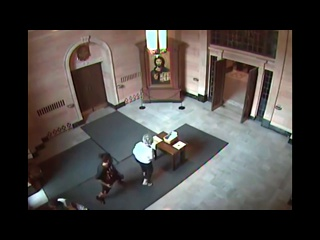

In [7]:
image

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm

# Directory with your images
image_dir = '/kaggle/input/embeddings-test'

# Storage for image embeddings
embeddings_dict = {}

# Loop through each image
for filename in tqdm(os.listdir(image_dir)[:20]):
    if filename.lower().endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        
        # Load image
        image = Image.open(image_path)

        # Generate embeddings
        with torch.no_grad():
            result = model.generate([[image]], device, output_len=200)

        # Assuming result shape is (1, 261, 2560)
        # Extract final embedding (e.g., last token or mean pooling)
        emb = result[0].mean(dim=0)  # shape (2560,)

        # Convert to NumPy array and store
        embeddings_dict[filename] = emb.cpu().numpy()

# Option 1: Save as .npy file
np.save('image_embeddings.npy', embeddings_dict)

# Option 2: Or convert to full array if needed
# image_names = list(embeddings_dict.keys())
# embedding_array = np.stack([embeddings_dict[name] for name in image_names])


## Sample prompts for search 
testing_prompts = [

]

In [ ]:
embeddings_dict

## Testing text 

In [ ]:
ground_truths = ['Abuse_Abuse010_x264_frame322.jpg',
                'Abuse_Abuse001_x264_frame1128.jpg',
                 'Arrest_Arrest017_x264_frame2655.jpg']
desc_prompts = [
    'traffic cones and a street person in motorcycle crossing',
    'inside of home picture of jesus open door',
    'a lot of cars in a street blocking'
    
]

## Check metrics cosine and euclidean

In [ ]:
embeddings_dict_search = {}

for i in range(len(desc_prompts)):
    with torch.no_grad():
        result = model.generate([[desc_prompts[i]]], device, output_len=200)
    emb = result[0].mean(dim=0)  # shape (2560,)

        # Convert to NumPy array and store
    embeddings_dict_search[ground_truths[i]] = emb.cpu().numpy()

# Option 1: Save as .npy file
np.save('image_embeddings_search.npy', embeddings_dict_search)

In [ ]:
embeddings_dict_search

## Manually evaluating embeddings by testing 

In [ ]:
# Each jpg in the dataset open like
#
#dataset:/kaggle/input/embeddings-test
# With Image Input
from PIL import Image

def read_image_kaggle(path):
    return Image.open(path)

# Example usage:
image_path = '/kaggle/input/embeddings-test/Abuse_Abuse001_x264_frame1049.jpg'
image = read_image_kaggle(image_path)

## Case 1

In [8]:
result = model.generate([[image]], device, output_len=200)
emb_image = result[0].mean(dim=0)  # shape (2560,)

In [9]:
result = model.generate([['dog']], device, output_len=200)
emb_bad_desc = result[0].mean(dim=0)  # shape (2560,)

In [10]:
result = model.generate([['two people in a room']], device, output_len=200)
emb_similar_desc = result[0].mean(dim=0)  # shape (2560,)

## Compute distances 

In [11]:
import torch
import torch.nn.functional as F

In [12]:
sim_similar = F.cosine_similarity(emb_image, emb_similar_desc, dim=0)
sim_bad = F.cosine_similarity(emb_image, emb_bad_desc, dim=0)

print("Similarity with similar description:", sim_similar.item())
print("Similarity with bad description:", sim_bad.item())

Similarity with similar description: 0.4951229989528656
Similarity with bad description: 0.2570539712905884
